In [150]:
import pandas as pd
import numpy as np
import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use(["science"])

---
# Load dataset

In [151]:
# Download the data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/emrearapcic-uevak/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1


In [152]:
import os.path

spam_data = pd.read_csv(os.path.join(path, "spam.csv"), encoding='latin-1')
spam_data.rename(columns={'Unnamed: 2': 'Mistake_1', "Unnamed: 3" : 'Mistake_2', "Unnamed: 4" : 'Mistake_3'}, inplace=True)
spam_data.rename(columns={'v1' : 'spam', 'v2' : 'sms'}, inplace=True)
spam_data.head()

,spam,sms,Mistake_1,Mistake_2,Mistake_3
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [153]:
spam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   spam       5572 non-null   object
 1   sms        5572 non-null   object
 2   Mistake_1  50 non-null     object
 3   Mistake_2  12 non-null     object
 4   Mistake_3  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


---
# Clean up the data-set

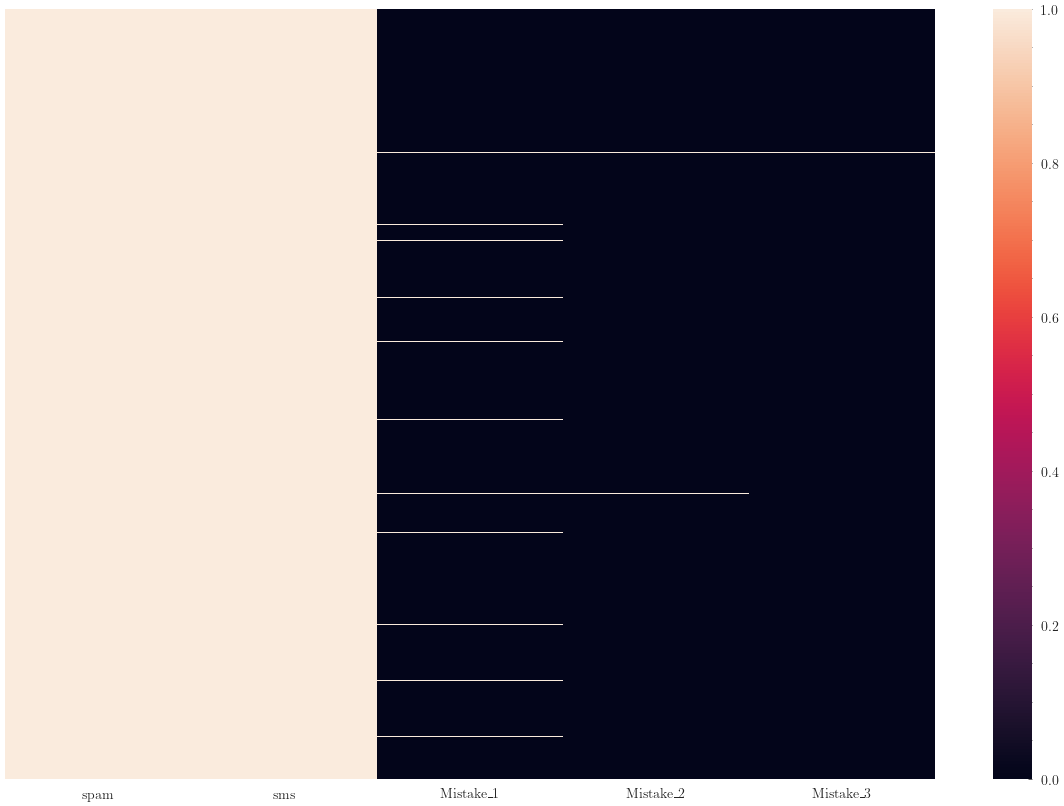

In [181]:
plt.figure(figsize=(15,10))
sns.heatmap(data=spam_data.notna(), vmin=0, vmax=1, yticklabels=False)
plt.savefig('Images/Missing_Values_Pre_Processing_Visualized.pdf', dpi=600)

In [193]:
sms_with_non_empty_mistakes = spam_data[spam_data['Mistake_1'].notna()]
some_examples_of_mistake_values = sms_with_non_empty_mistakes.loc[sms_with_non_empty_mistakes['sms'].str.len() < 20, 'sms' : 'Mistake_3']

some_examples_of_mistake_values.to_latex('Tables/Mistake_Values_Example_Table.tex', position='h!', label='Tab:Mistake_Values_Example', index = False, )
some_examples_of_mistake_values

,sms,Mistake_1,Mistake_2,Mistake_3
281,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
2087,\alright babe,justthought iåÕd sayhey! how u doin?nearly th...,NaN,NaN
4992,\HEY KATE,HOPE UR OK... WILL GIVE U A BUZ WEDLUNCH. GO ...,NaN,NaN
5268,\ER,ENJOYIN INDIANS AT THE MO..yeP. SaLL gOoD Heh...,NaN,NaN


Text(0.5, 1.0, 'First Character Count')

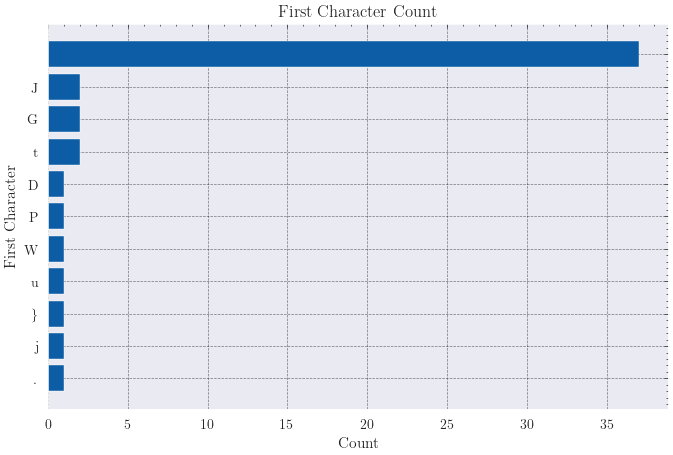

In [171]:
first_char = sms_with_non_empty_mistakes['Mistake_1'].str[0].value_counts(ascending=True)
plt.figure(figsize=(8,5))
plt.barh(y=first_char.index.values, width=first_char)
plt.ylabel("First Character")
plt.xlabel("Count")
plt.title("First Character Count")

In [136]:
def combine_text(s : pd.Series):
  str = s.loc['sms']
  for i in range(1,4):
    temp_str = s.loc[f'Mistake_{i}']
    if temp_str == '':
      break

    str = f'{str},{temp_str}'

  return str

spam_data['sms'] = spam_data[['sms', 'Mistake_1', 'Mistake_2', 'Mistake_3']].fillna(value="").agg(combine_text, axis=1)
spam_data.dropna(axis='columns', how='any', inplace=True)
spam_data['spam'] = spam_data['spam'].map({'ham': False, 'spam': True})

<Axes: >

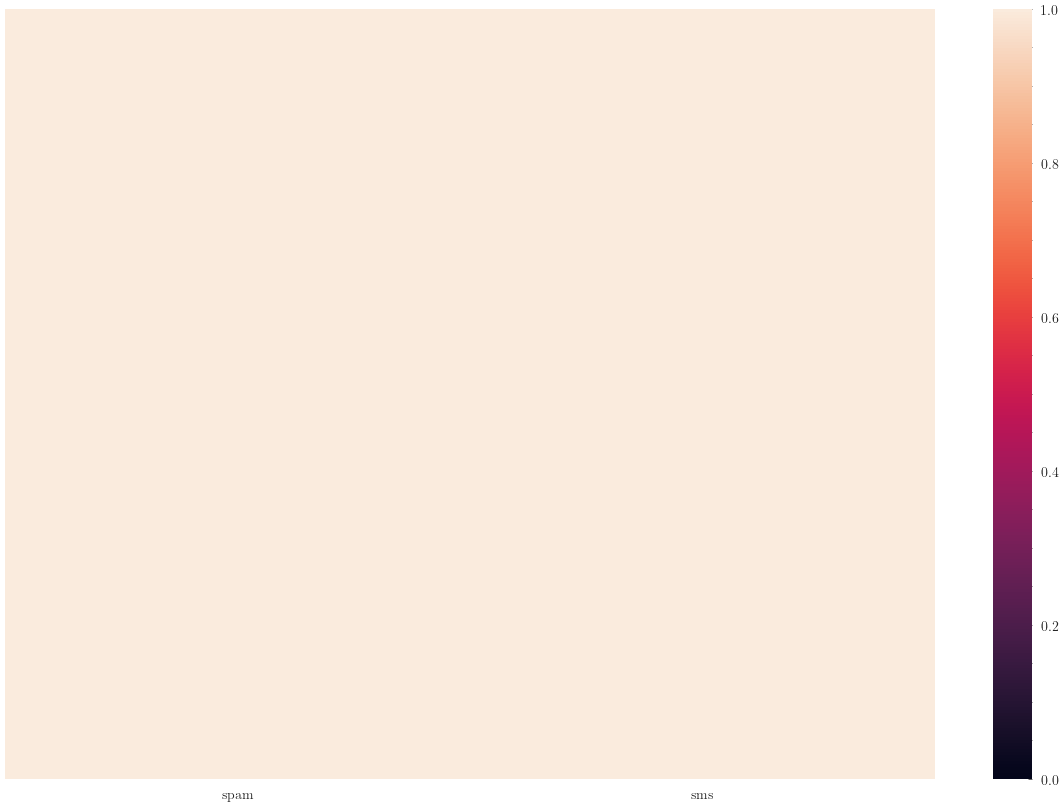

In [143]:
plt.figure(figsize=(15, 10))
sns.heatmap(data=spam_data.notna(), vmin=0, vmax=1, yticklabels=False)

---
# Feature analysis

<Axes: xlabel='spam', ylabel='count'>

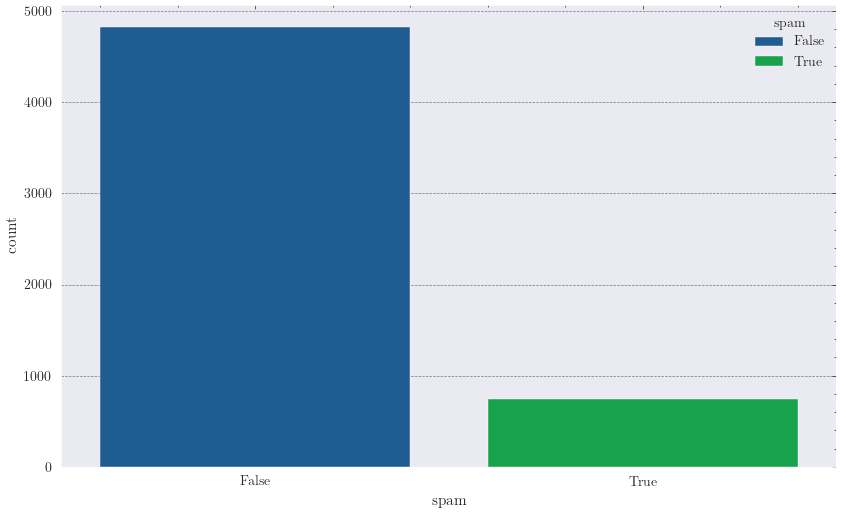

In [138]:
plt.figure(figsize=(10,6))
sns.countplot(data=spam_data, x="spam", hue="spam")

([<matplotlib.patches.Wedge at 0x16c57bed0>,
 [Text(-1.0038715425384215, 0.4497131597824666, 'Ham'),
  Text(1.0038714746336121, -0.4497133113628473, 'Spam')],
 [Text(-0.547566295930048, 0.24529808715407267, '86.6\\%'),
  Text(0.5475662588910611, -0.24529816983428032, '13.4\\%')])

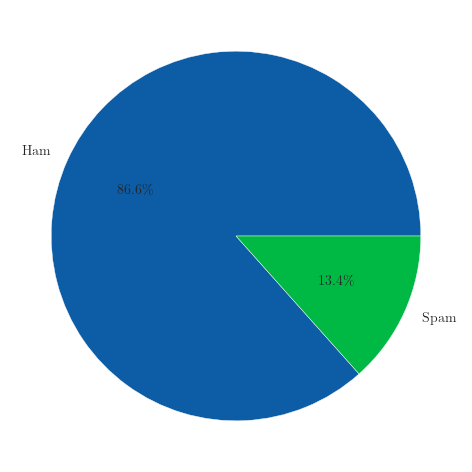

In [139]:
plt.figure(figsize=(10,6))

spam_data_count = spam_data['spam'].value_counts()
plt.pie(x=spam_data_count, autopct="%1.1f%%", labels=['Spam' if s else 'Ham' for s in spam_data_count.index.values])

---
# Split the data into train and test

In [140]:
from sklearn.model_selection import train_test_split
X = spam_data.drop('spam', axis=1)
y = spam_data['spam']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.squeeze()
X_test  = X_test.squeeze()
X_test = X_test.squeeze()
y_test = y_test.squeeze()

---
# Data preprocessing

In [141]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

spam_filter = Pipeline([
  ( 'vectorizer', CountVectorizer(
    lowercase=True,
    token_pattern=r"[a-zA-Z]+",
    stop_words="english",
    ngram_range=(1, 2),
  )),
  ('classifier', MultinomialNB())
])

spam_filter.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vectorizer', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


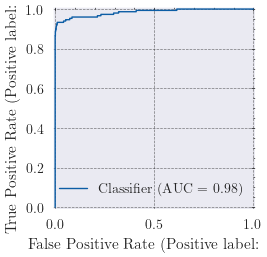

In [142]:
from sklearn.metrics import RocCurveDisplay
y_true = y_test.map(lambda x : 1 if x else 0)
y_score = spam_filter.predict_proba(X_test)[:,1]
RocCurveDisplay.from_predictions(y_true, y_score, pos_label=1)